In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches



# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
_ = model.eval()

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
img = Image.open('../datasets/images/office.jpg')

In [3]:
# Transform the image
img_tensor = F.to_tensor(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension


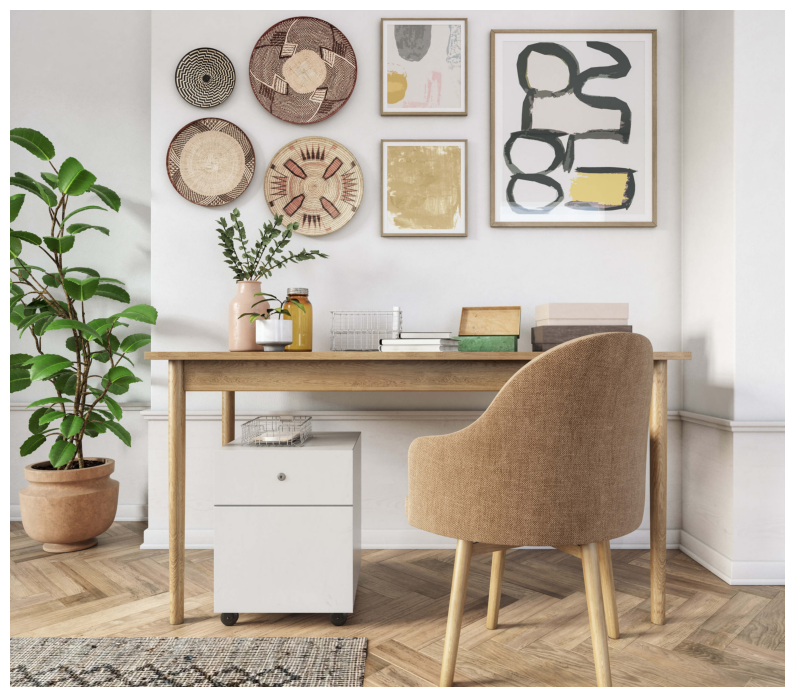

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
_ = plt.axis('off')

In [7]:
# Forward pass through the model
with torch.no_grad():
    prediction = model(img_tensor)

In [8]:
class_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

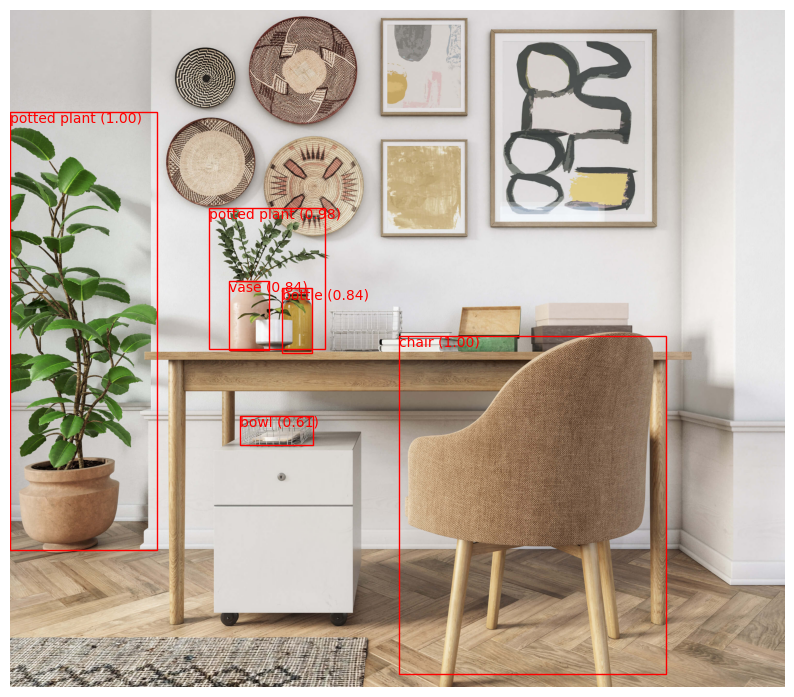

In [12]:
threshold = 0.5

# Filter boxes based on confidence scores
filtered_boxes = prediction[0]['boxes'][prediction[0]['scores'] > threshold]
filtered_scores = prediction[0]['scores'][prediction[0]['scores'] > threshold]
filtered_labels = prediction[0]['labels'][prediction[0]['scores'] > threshold]

# Plot the image with bounding boxes and class names
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)

# Add bounding boxes and labels to the plot
for i in range(filtered_boxes.size(0)):
    box = filtered_boxes[i].cpu().numpy()
    score = filtered_scores[i].item()
    label = filtered_labels[i].item()

    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add class name and score as text
    class_name = class_names[label]
    ax.text(box[0], box[1], f'{class_name} ({score:.2f})', color='r', verticalalignment='top')

plt.axis('off')  # Turn off axis labels
plt.show()

In [35]:
%pip install -q roboflow supervision

Note: you may need to restart the kernel to use updated packages.


In [24]:
try:
    from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
except ImportError:
    %pip install git+https://github.com/facebookresearch/segment-anything.git
    pip install -q roboflow supervision
    from segment_anything import SamPredictor, sam_model_registry

In [25]:
# Place the model weights
import os
pth_path = os.path.expanduser('~/.cache/torch/sam.pth')
pth_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

if not os.path.exists(pth_path):
    import urllib.request
    print(f'Downloading SAM weights to {pth_path}')
    urllib.request.urlretrieve(pth_url, pth_path)


In [36]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=pth_path)
_ = sam.to(device=DEVICE)

In [37]:
import cv2
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread('../datasets/images/office.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

In [52]:
import supervision as sv

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(result)
annotated_image = mask_annotator.annotate(image_bgr, detections)

(-0.5, 2999.5, 2620.5, -0.5)

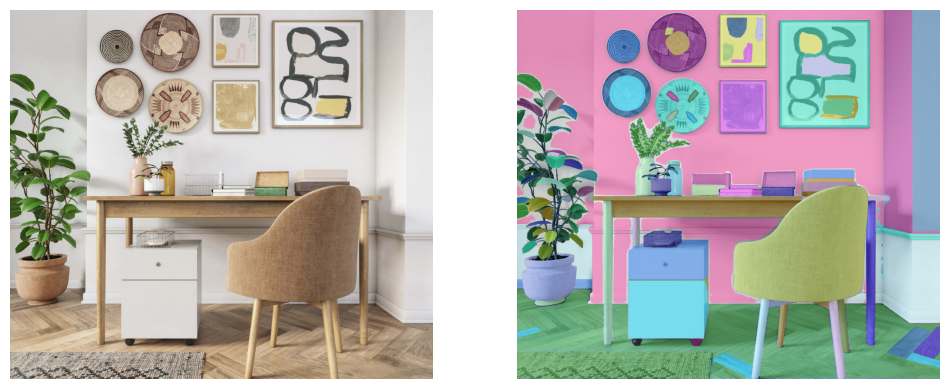

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_tensor.squeeze(0).permute(1, 2, 0))
ax[1].imshow(annotated_image)

ax[0].axis('off')
ax[1].axis('off')